In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df_future = pd.read_csv('Final_data.csv').drop(columns=["CPI","Population Estimate"])

In [3]:
df_future.head(5)

,Date,Median Annual Income,Petrol Price,Diesel Price,Google Search Index,All Cars,ULEV,Grants,Charging Points
0,2011-10-31,26719.28962,1.3473,1.4027,23.0,206427.0,31.0,0.0,0.0
1,2011-11-30,26652.97814,1.3317,1.4110,22.0,207544.0,31.0,0.0,0.0
2,2011-12-31,26584.45628,1.3241,1.4077,12.0,208700.0,31.0,0.0,0.0
3,2012-01-31,26515.93443,1.3410,1.4245,21.0,209690.0,31.0,0.0,0.0
4,2012-02-29,26451.83333,1.3621,1.4392,26.0,210618.0,33.0,0.0,0.0


In [4]:
df_future['Date']=pd.to_datetime(df_future['Date'])

In [5]:
df_future.set_index('Date', inplace=True)

In [6]:
df_future.isna().sum()

Median Annual Income    80
Petrol Price            77
Diesel Price            77
Google Search Index     77
All Cars                84
ULEV                    77
Grants                  77
Charging Points         77
dtype: int64

In [7]:
df=df_future.dropna()

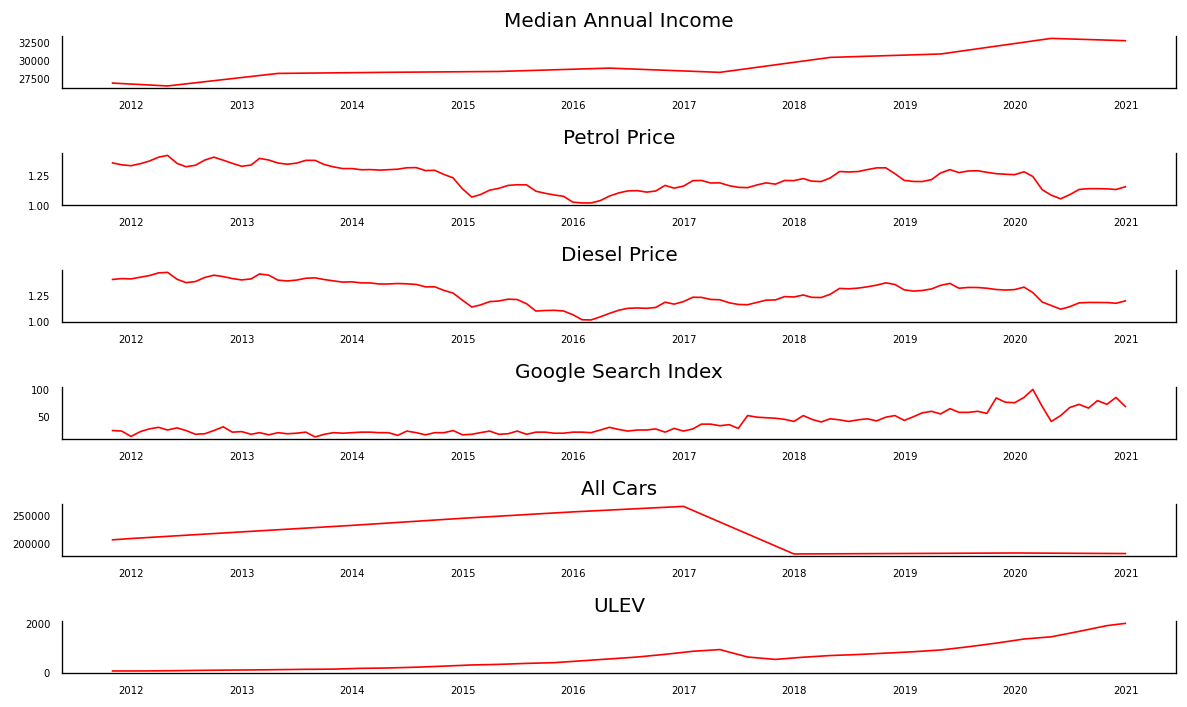

In [8]:
fig, axes = plt.subplots(nrows=6, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        


,Median Annual Income_x,Petrol Price_x,Diesel Price_x,Google Search Index_x,All Cars_x,ULEV_x,Grants_x,Charging Points_x
Median Annual Income_y,1.0000,0.0013,0.0041,0.0000,0.0000,0.0121,0.0013,0.0024
Petrol Price_y,0.0639,1.0000,0.0525,0.2123,0.3445,0.2109,0.1166,0.1709
Diesel Price_y,0.2540,0.3312,1.0000,0.1988,0.1441,0.2902,0.0363,0.3212
Google Search Index_y,0.0001,0.0038,0.0059,1.0000,0.0293,0.0001,0.0000,0.0002
All Cars_y,0.0000,0.0001,0.0000,0.0026,1.0000,0.0000,0.0004,0.4230
ULEV_y,0.0001,0.1496,0.0154,0.0334,0.0000,1.0000,0.1057,0.0005
Grants_y,0.4350,0.0000,0.0000,0.0040,0.0000,0.0057,1.0000,0.0000
Charging Points_y,0.0000,0.0978,0.0796,0.0000,0.0000,0.0006,0.0000,1.0000


In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Median Annual Income ::  355.68    > 143.6691  =>   True
Petrol Price ::  250.97    > 111.7797  =>   True
Diesel Price ::  161.89    > 83.9383   =>   True
Google Search Index ::  111.47    > 60.0627   =>   True
All Cars ::  65.4      > 40.1749   =>   True
ULEV   ::  33.39     > 24.2761   =>   True
Grants ::  14.07     > 12.3212   =>   True
Charging Points ::  0.02      > 4.1296    =>   False


In [11]:
df.shape

(111, 8)

In [12]:
nobs = 18
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(93, 8)
(18, 8)


In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [14]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4762
 No. Lags Chosen       = 1
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.8966. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Petrol Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5951
 No. Lags Chosen       = 2
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.4861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 N

In [15]:
#1st differentiation
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0013
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.7528. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Petrol Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9879
 No. Lags Chosen       = 1
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 Null Hypothesis: Data has

In [16]:
#2nd differentiation
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2743
 No. Lags Chosen       = 11
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Petrol Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.474
 No. Lags Chosen       = 9
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

In [17]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  22.12371408385475
BIC :  24.12356182011896
FPE :  4078844798.1045594
HQIC:  22.93017024449416 

Lag Order = 2
AIC :  22.118774796877247
BIC :  25.921634867479167
FPE :  4193404716.273633
HQIC:  23.651598559623558 

Lag Order = 3
AIC :  22.394347459776696
BIC :  28.02465840177262
FPE :  6047541440.273831
HQIC:  24.662658408008035 

Lag Order = 4
AIC :  22.16205736754207
BIC :  29.644813037942185
FPE :  5800172062.707796
HQIC:  25.175132333907342 

Lag Order = 5
AIC :  22.317859930008197
BIC :  31.678626362230872
FPE :  9649285680.102541
HQIC:  26.0851347452899 

Lag Order = 6
AIC :  19.88594549972944
BIC :  31.150878353190667
FPE :  1574152674.356971
HQIC:  24.41701657278118 

Lag Order = 7
AIC :  19.65733917486962
BIC :  32.853201797161894
FPE :  3670451488.0648823
HQIC:  24.961964874653585 



C:\Users\anich\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [39]:
model_fitted = model.fit(4)
model_fitted.summary()
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col,':', round(val, 2))

Median Annual Income : 1.78
Petrol Price : 2.01
Diesel Price : 2.02
Google Search Index : 2.13
All Cars : 1.8
ULEV : 1.73
Grants : 1.97
Charging Points : 2.03


In [40]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 3

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 3.92877000e+00,  1.68000000e-02,  9.30000000e-03,
        -4.00000000e+00,  7.00000000e+00,  3.00000000e+00,
         2.69905533e+01,  1.00000000e+00],
       [-1.30959000e+00,  3.92000000e-02,  1.96000000e-02,
        -8.00000000e+00, -2.00000000e+00, -1.00000000e+00,
        -8.99685110e+00, -1.00000000e+00],
       [ 1.45950030e+02, -2.75000000e-02, -1.60000000e-02,
         1.50000000e+01,  3.00000000e+00,  2.00000000e+01,
         8.99685110e+00,  1.00000000e+00],
       [-5.97540000e+00, -5.26000000e-02, -6.49000000e-02,
        -1.70000000e+01, -3.00000000e+00, -2.00000000e+00,
        -8.99685110e+00, -1.00000000e+00]])

In [41]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Median Annual Income_2d,Petrol Price_2d,Diesel Price_2d,Google Search Index_2d,All Cars_2d,ULEV_2d,Grants_2d,Charging Points_2d
Date,,,,,,,,
2019-07-31,18.112263,0.039062,0.044987,11.694556,792.999036,14.836587,44.788015,0.442138
2019-08-31,-52.081936,0.012514,0.016871,-8.218128,-833.630942,11.463633,-25.323628,-0.381849
2019-09-30,62.120785,0.010072,0.002297,8.655308,826.320408,-10.253487,37.329130,0.249563
2019-10-31,-59.097204,-0.026325,-0.019304,-10.000968,-207.312247,4.258271,-13.937418,-0.116344
2019-11-30,12.855878,-0.008448,-0.008096,8.871988,11.111737,5.584143,12.635204,0.054718
2019-12-31,-0.918798,0.004564,0.000146,-5.230937,-429.972987,2.666426,-3.991989,0.157637
2020-01-31,-8.108846,0.016081,0.015763,1.426742,183.700325,-0.498355,13.344040,0.138094
2020-02-29,-3.308737,-0.009992,-0.005560,-0.025055,171.159414,-4.442305,-5.683844,0.165850
2020-03-31,15.851557,0.000790,-0.000651,0.185221,46.981459,2.215529,5.489824,-0.120150


In [42]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

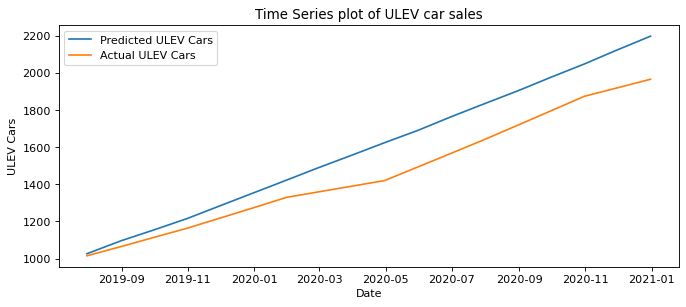

In [43]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['ULEV_forecast']]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,4), dpi=80)
plt.plot((df_results["ULEV_forecast"]).astype(int))
plt.plot(df_test["ULEV"][-nobs:])
plt.xlabel("Date")
plt.ylabel("ULEV Cars")
plt.title("Time Series plot of ULEV car sales")
plt.legend(['Predicted ULEV Cars', 'Actual ULEV Cars'])

In [44]:
preds=(df_results["ULEV_forecast"]).astype(int)
y_values=df["ULEV"][-18:]

In [45]:
import sklearn.metrics as sm
print("R2 score =", round(sm.r2_score(y_values, preds), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_values, preds), 2)) 


R2 score = 0.73
Mean absolute error = 135.39


PREDICTING ULEV CAR SALES till 2026:

In [46]:
fc = model_fitted.forecast(y=forecast_input, steps=102)
df_forecast_2027 = pd.DataFrame(fc, index=df_future.index[-102:], columns=df_future.columns + '_2d')
df_results = invert_transformation(df_train, df_forecast_2027, second_diff=True)        
df_results['ULEV_forecast']


Date
2019-07-31     1026.836587
2019-08-31     1095.136806
2019-09-30     1153.183538
2019-10-31     1215.488541
2019-11-30     1283.377687
                  ...     
2027-08-31    10776.292160
2027-09-30    10916.121841
2027-10-31    11056.756563
2027-11-30    11198.196316
2027-12-31    11340.441103
Name: ULEV_forecast, Length: 102, dtype: float64

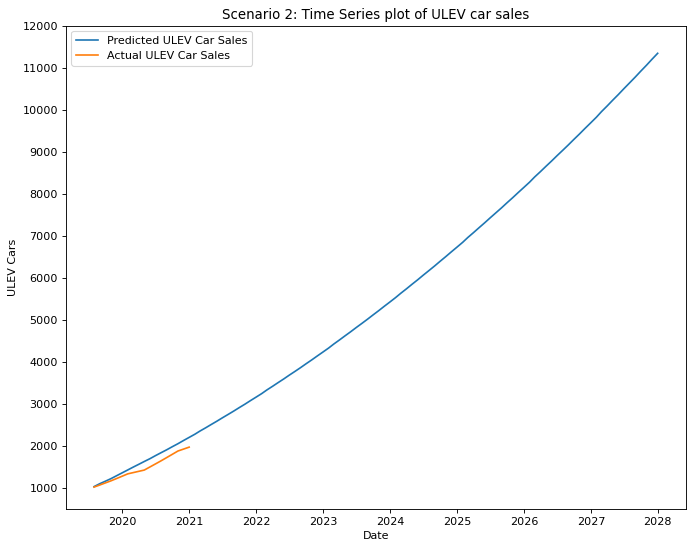

In [47]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)
plt.plot((df_results["ULEV_forecast"]).astype(int))
plt.plot(df_test["ULEV"][-nobs:])
plt.xlabel("Date")
plt.ylabel("ULEV Cars")
plt.title("Scenario 2: Time Series plot of ULEV car sales")
plt.legend(['Predicted ULEV Car Sales', 'Actual ULEV Car Sales'])
y_ticks=[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]
y_labels=[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]
plt.yticks(ticks=y_ticks,labels=y_labels)
plt.show()

In [48]:
charging_points_240_grants=df_results["ULEV_forecast"].astype(int)

In [49]:
charging_points_240_grants.to_csv("charging_points_200_grants.csv")